In [1]:
import numpy as np
import random
import torch
from scipy.special import erf
from math import*
from scipy.integrate import quad as itg
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [2]:
from model import AE, AE_0

In [3]:
# import argparse
# parser=argparse.ArgumentParser(description="Job launcher")

# parser.add_argument("-n",type=int)    
# parser.add_argument("-m",type=float)  #norm of mu. Set to 1. in the whole manuscipt.
# parser.add_argument("-s",type=float)  #sigma

# args=parser.parse_args()

# nrm=args.m
# sigma=args.s
# d=100  #dimension of the data
# n_list=[2,4,6,8,16,32,64,128,256,512,1024]
# ntot=n_list[args.n]   #number of samples

In [4]:
nrm = 1

σ = 1
# number of samples
ntot = 4
# dimensions
d = 200
# d = 100
# training
epochs = 800
# epochs = 400
# imbalance prob
p = 0.9
# generation size
N = 1000
# N = 500
# std
std = 1
# std = d ** .5
# number of discretization steps from ODE
N_steps=100

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
from torch.func import grad

In [7]:
# Schedule functions
def α(t):
  return (1-t) * std
# def α(t):
#   return (1-t) * (std - t**2*(std+1))
# τ = 0.25  # time of transition
# def α(t):
#   return (τ  - (t - τ)) if t>τ else (τ - (std/τ-1)*(t-τ))
def β(t):
  return t
α_dot = grad(α)
β_dot = grad(β)

In [8]:
gen0 = torch.Generator().manual_seed(42)
gen1 = torch.Generator().manual_seed(67)
gen3 = torch.Generator().manual_seed(4122)

ξ=torch.randn(ntot,d,generator=gen0)                               # x_0^μ. We fixed the random seed for reproducibility
η=torch.randn(ntot,d,generator=gen1)                               # z^μ. We fixed the random seed for reproducibility
s=torch.sign(2.*(torch.rand(ntot,generator=gen3)[:ntot] < p) -1 )  # s^μ

μ=torch.ones(d)
ξ_tot=torch.sum(ξ.T*s,1).flatten()/ntot # ξ vector
η_tot=torch.sum(η.T*s,1).flatten()/ntot # η vector

ξ_tot=ξ_tot.numpy()
η_tot=η_tot.numpy()
mu=μ.numpy()

summary={"Mag":[], "Mag_std":[],"t":[],"Mag_ξ":[],"Mag_η":[], "Cosine":[],"Norm":[], "p": [], "M_t": [], "b":[]}

# time step
dt=1/N_steps 

def get_x1(n,μ,σ):
    # constructs x(1)
    x_1=s.reshape(n,1)@μ.reshape(1,d)
    x_1+=η*σ
    return x_1

def get_x1_xt(n,μ,σ,t):
    # constructs x(1), x(t)
    x_1=get_x1(n,μ,σ)
    x_t=ξ*α(t)+ x_1*β(t)
    return x_t.to(device), x_1.to(device)

class generate_data(Dataset):
    # data loader object
    def __init__(self,n,μ,σ,t):
        self.μ=μ
        self.σ=σ
        self.t=t
        self.n=n
        self.X_t,self.X_1=get_x1_xt(n,μ,σ,t)

    def __getitem__(self,idx):
        return self.X_t[idx].to(device),self.X_1[idx].to(device)

    def __len__(self):
        return self.n

def quadloss(y_pred, y):
    # Loss function
    # The regularization enters at the level of the optimizer as the weight decay
    return torch.sum((y_pred-y)**2)/2

def train(train_loader, t):
    ae=AE(d).to(device)

    optimizer = torch.optim.Adam([
        {'params': [ae.w],    "weight_decay":1e-0},
        {'params': [ae.b],    "weight_decay":1e-0}, 
        {'params': [ae.c],    "weight_decay":0.}]
    ,lr=.04)

    ######## Training the DAE
    losses = []
    for _ in range(epochs):
        for x_t,x_1 in train_loader:   # Optimization steps
            x1_pred = ae(x_t)
            loss = quadloss(x1_pred,x_1)
            losses.append(loss.detach().cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # plot loss
    plt.semilogy(losses)
    plt.show()

    ###### Computing the corresponding velocity
    global X
    α_t = α(t)
    α_dot_t=α_dot(torch.tensor(t)).item()
    # α_dot_t = -1
    β_t = β(t)
    β_dot_t=β_dot(torch.tensor(t)).item()
    # β_dot_t = 1

    with torch.no_grad():
        X_1_pred = ae(torch.tensor(X.astype(np.float32))).numpy()
        r = 0 if α_t == 0 else α_dot_t/α_t
        v = (β_dot_t -  β_t * r ) * X_1_pred + r * X

    X+=v*dt

    summary['p'].append(np.mean(X@mu > 0))
    summary['M_t'].append(X@mu)

    Mt=((X.T*np.sign(X@mu)).T)@mu/d
    M_ξ=((X.T*np.sign(X@mu)).T)@ξ_tot/d
    M_η=((X.T*np.sign(X@mu)).T)@η_tot/d/σ

    X_=(X.T*np.sign(X@mu)).T
    Simi=X_@mu/np.sqrt(d)/np.sqrt(np.sum(X_**2, 1))

    summary["Mag"].append(Mt.mean())
    summary["Mag_std"].append(Mt.std())
    summary["t"].append(t+dt)
    summary["Mag_ξ"].append(M_ξ.mean())
    summary["Mag_η"].append(M_η.mean())
    summary["Cosine"].append(Simi.mean())
    summary["Norm"].append(np.sum(X_**2)/X_.shape[0]/d)
    summary["b"].append(ae.b.detach().cpu().numpy())

0.0


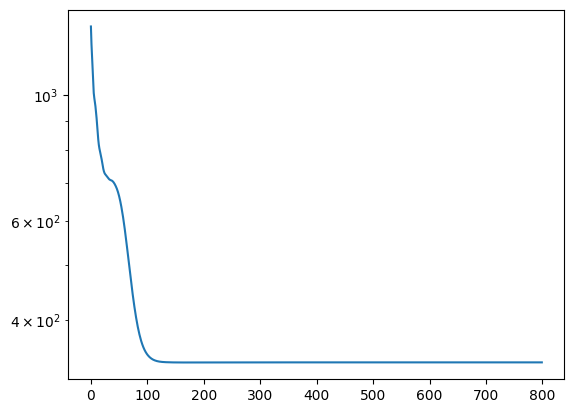

0.010101010101010102


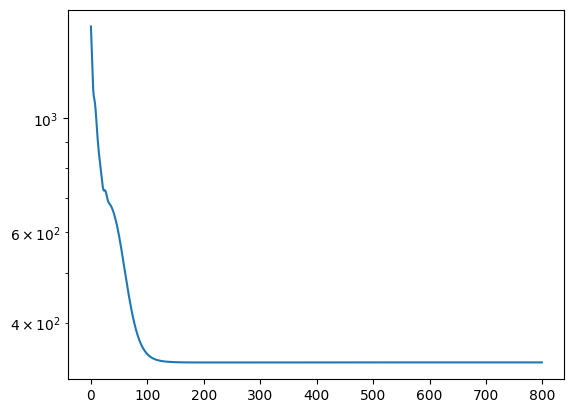

0.020202020202020204


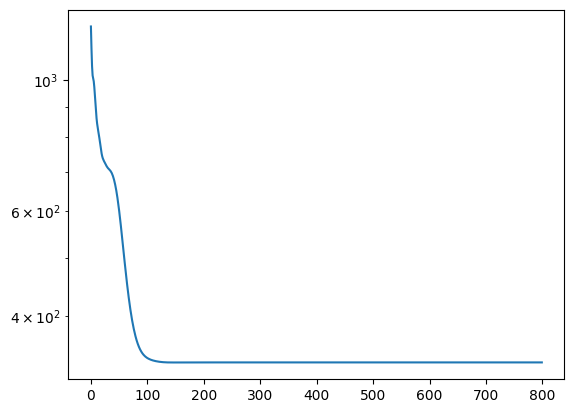

0.030303030303030304


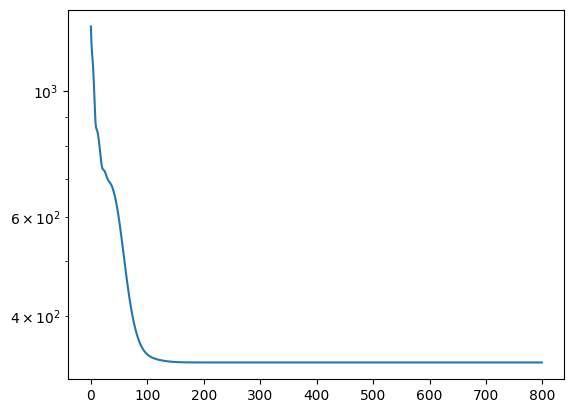

0.04040404040404041


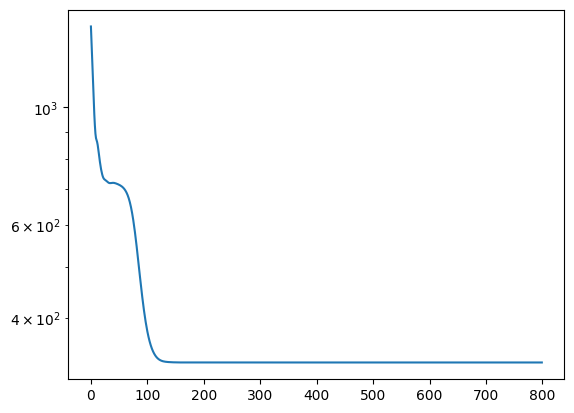

0.05050505050505051


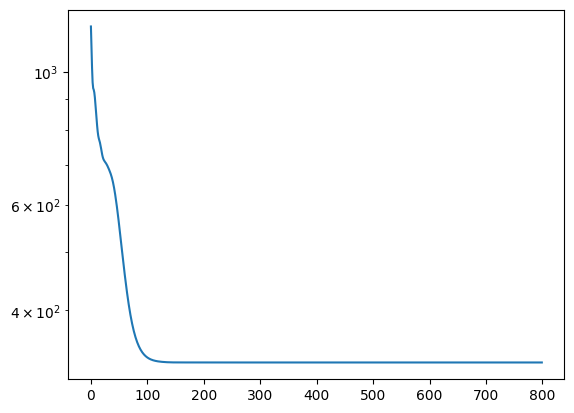

0.06060606060606061


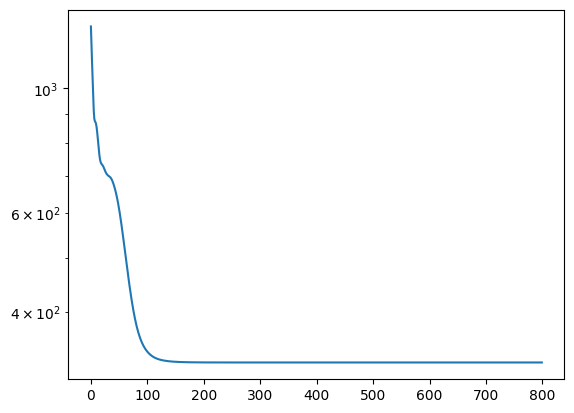

0.07070707070707072


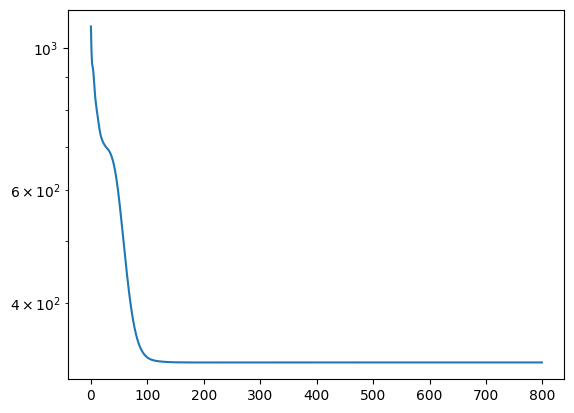

0.08080808080808081


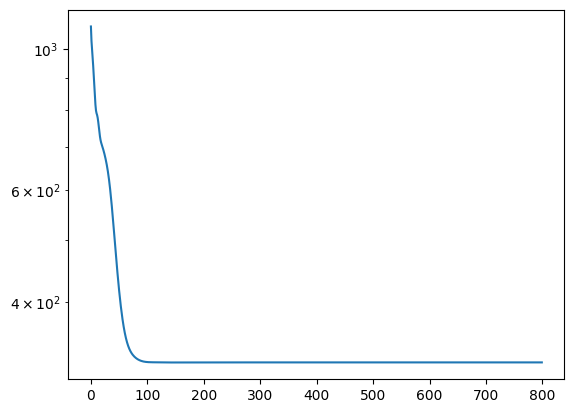

0.09090909090909091


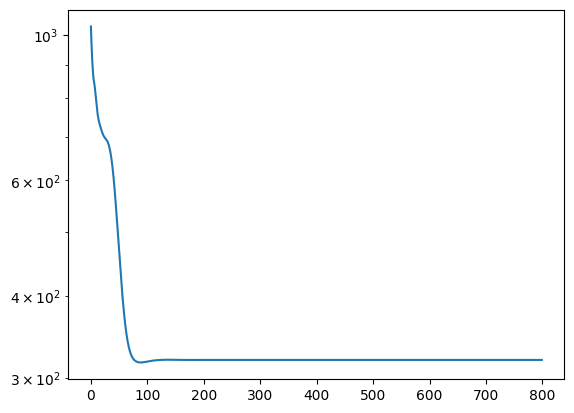

0.10101010101010102


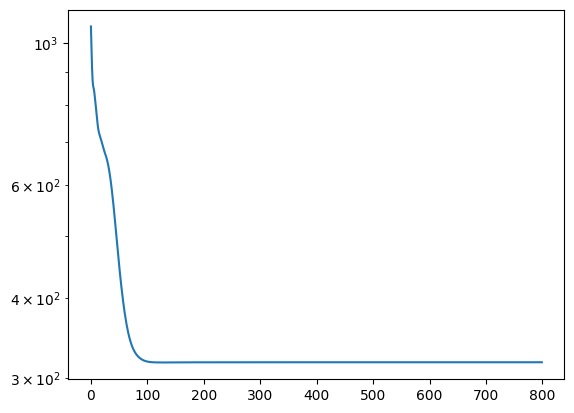

0.11111111111111112


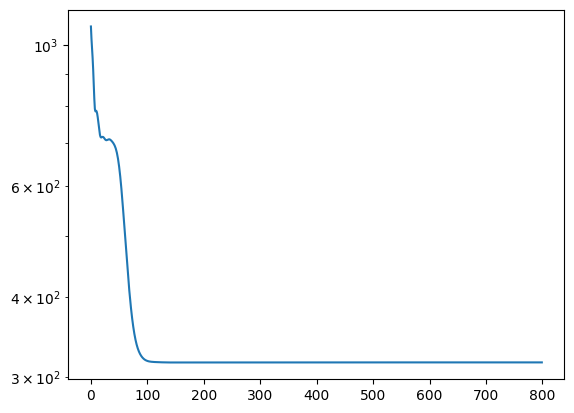

0.12121212121212122


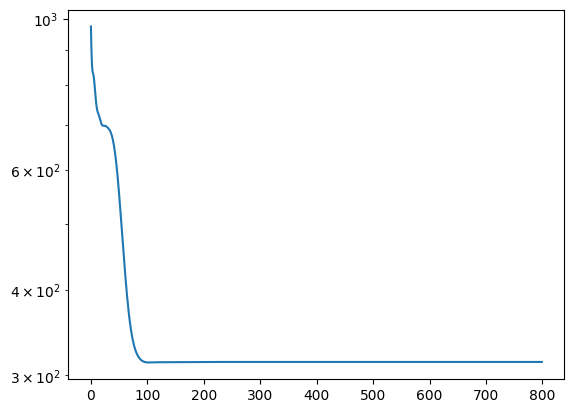

0.13131313131313133


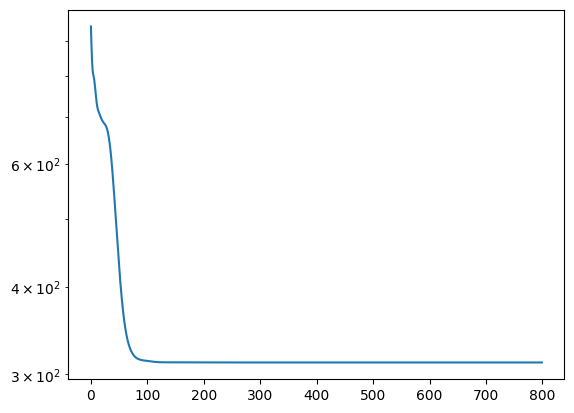

0.14141414141414144


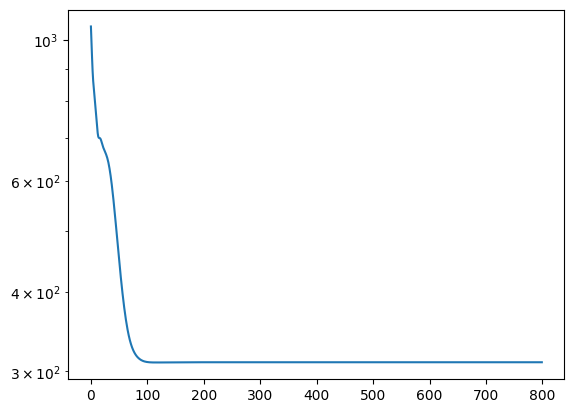

0.15151515151515152


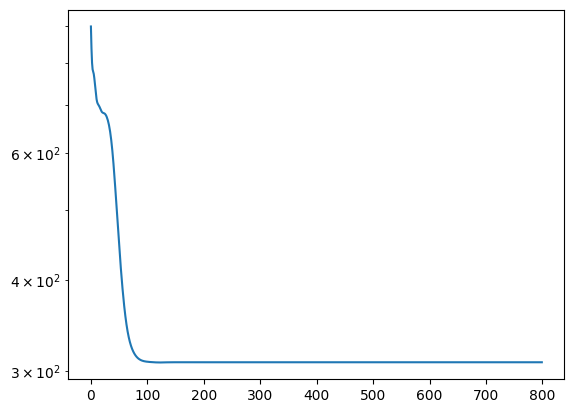

0.16161616161616163


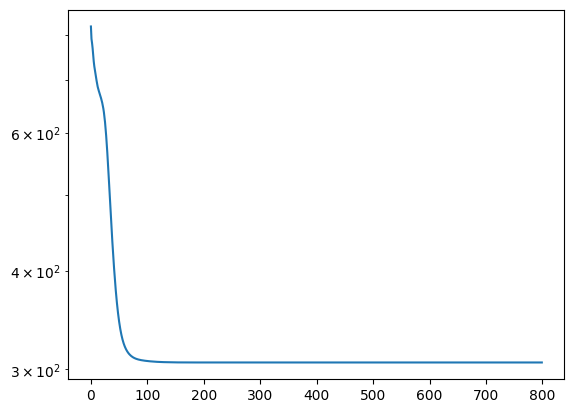

0.17171717171717174


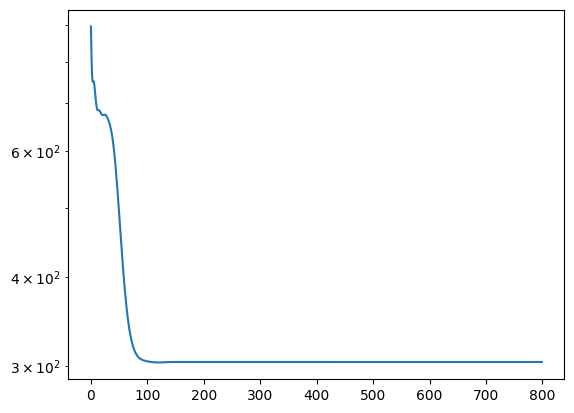

0.18181818181818182


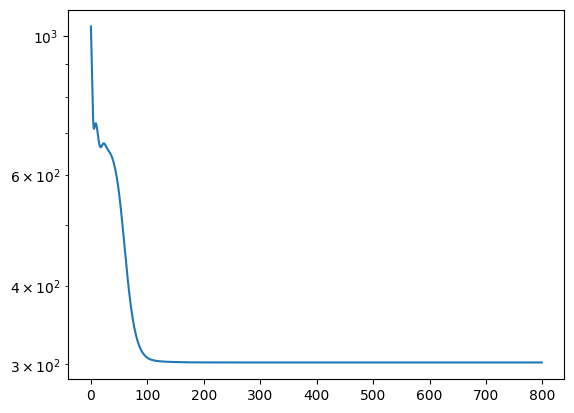

0.19191919191919193


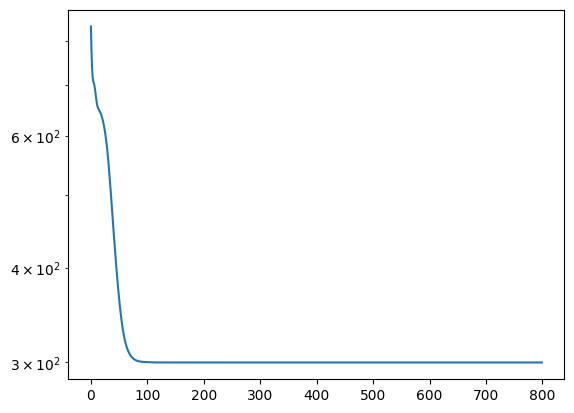

0.20202020202020204


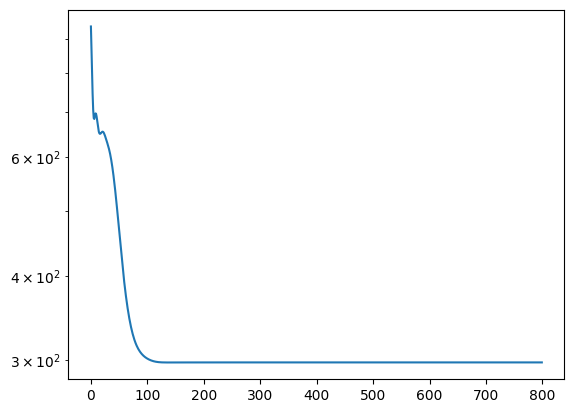

0.21212121212121213


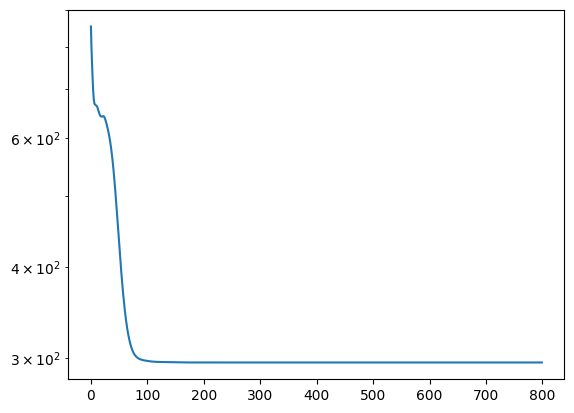

0.22222222222222224


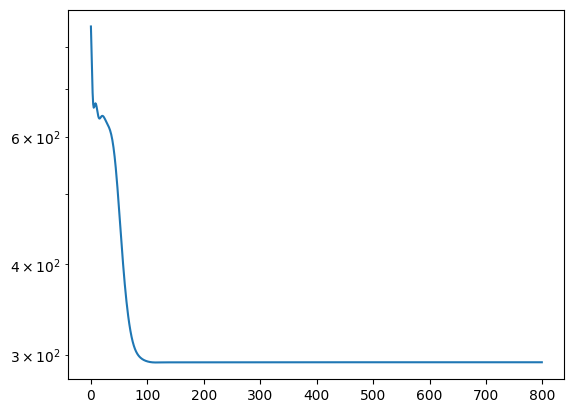

0.23232323232323235


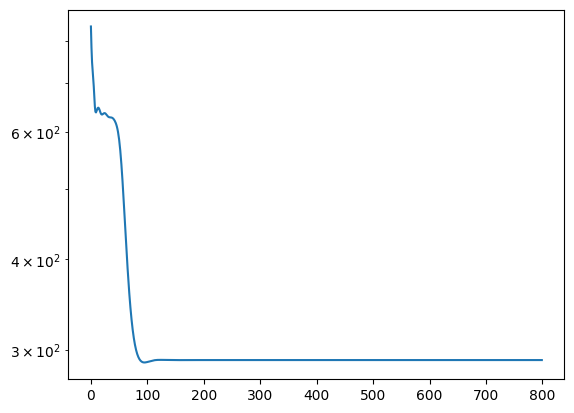

0.24242424242424243


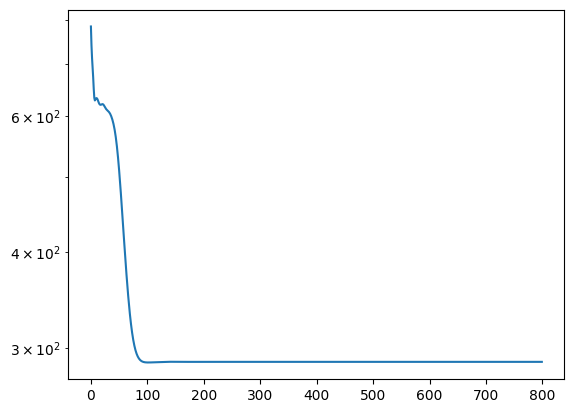

0.25252525252525254


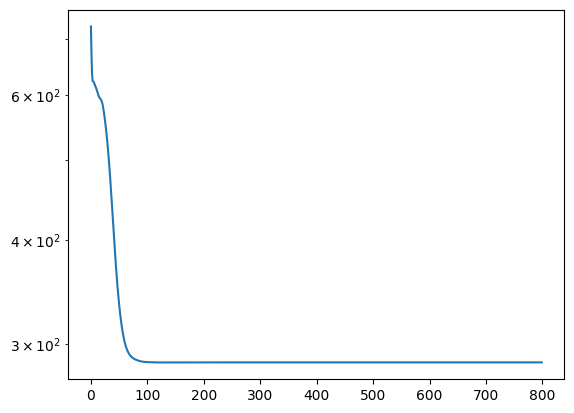

0.26262626262626265


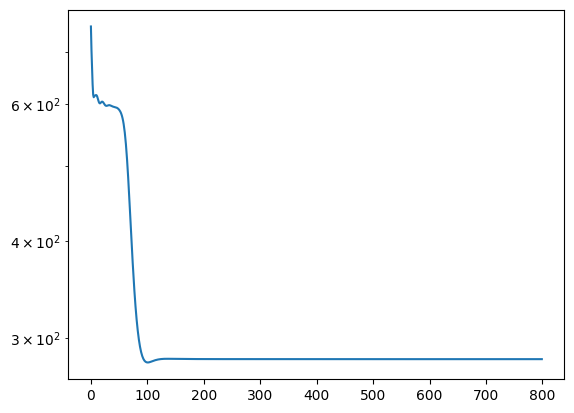

0.27272727272727276


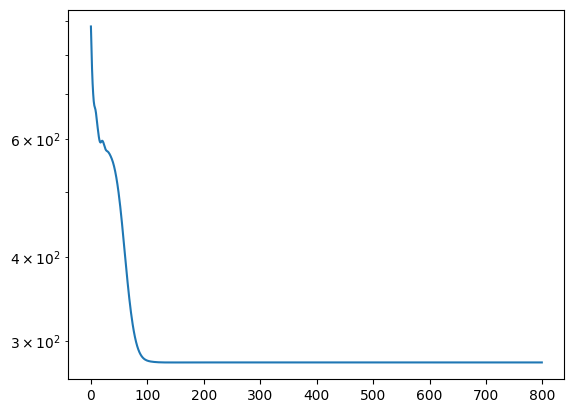

0.2828282828282829


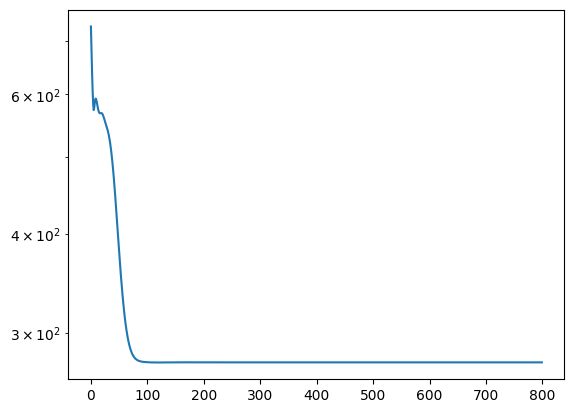

0.29292929292929293


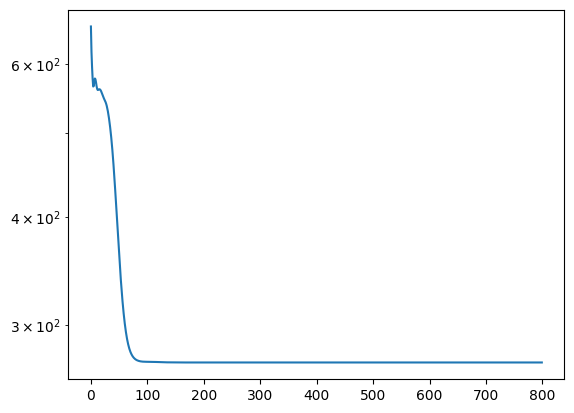

0.30303030303030304


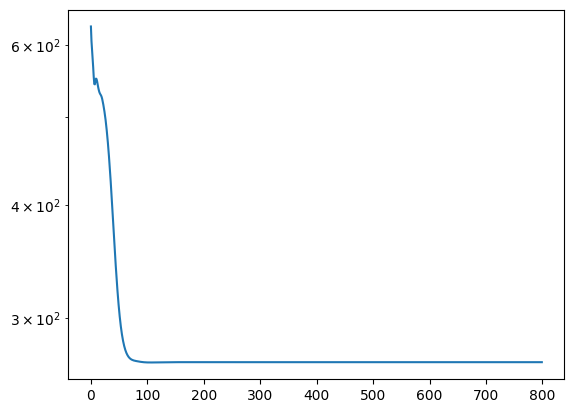

0.31313131313131315


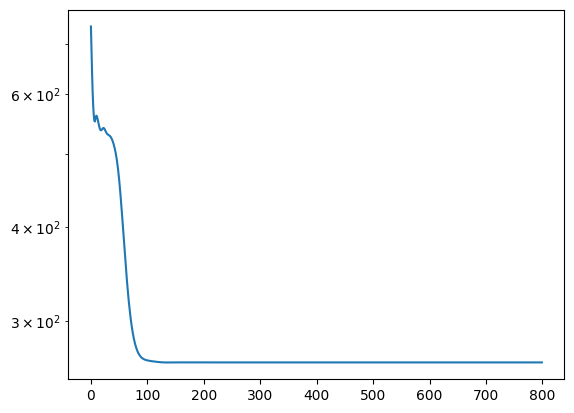

0.32323232323232326


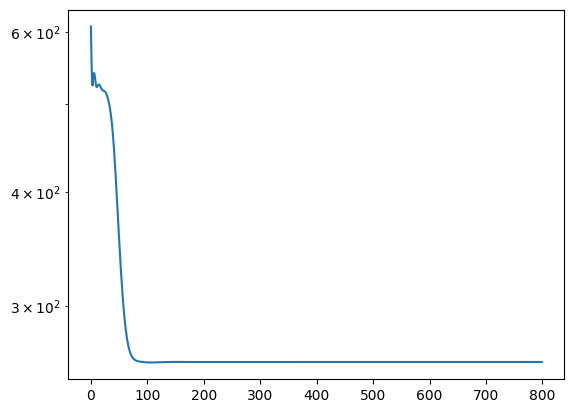

0.33333333333333337


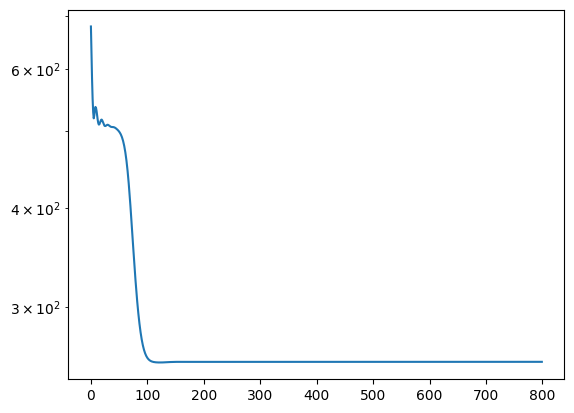

0.3434343434343435


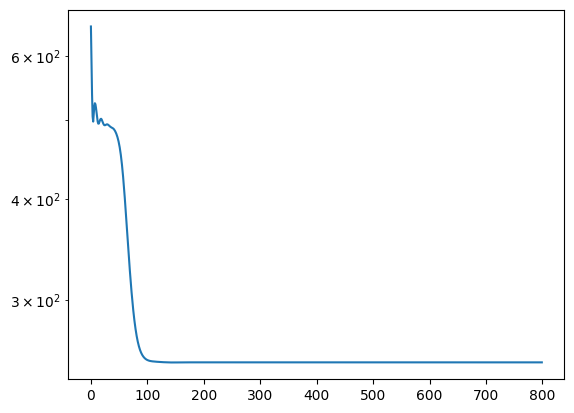

0.3535353535353536


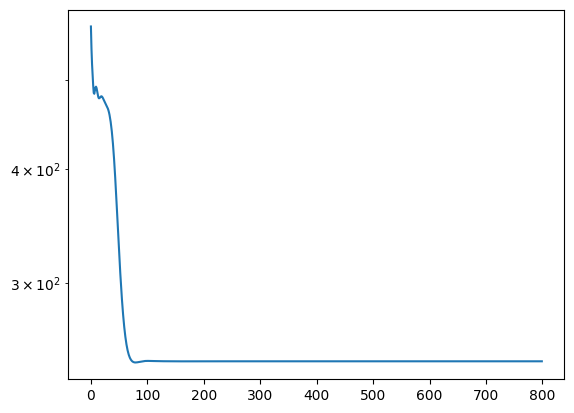

0.36363636363636365


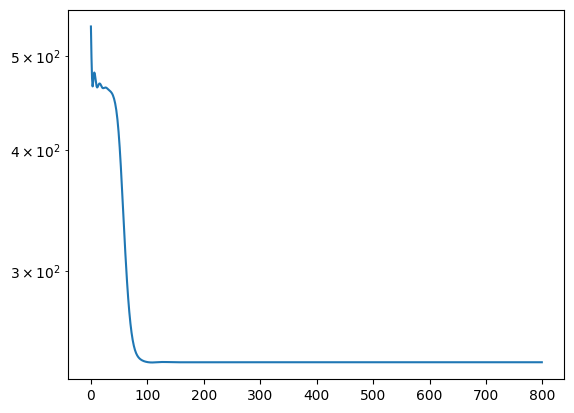

0.37373737373737376


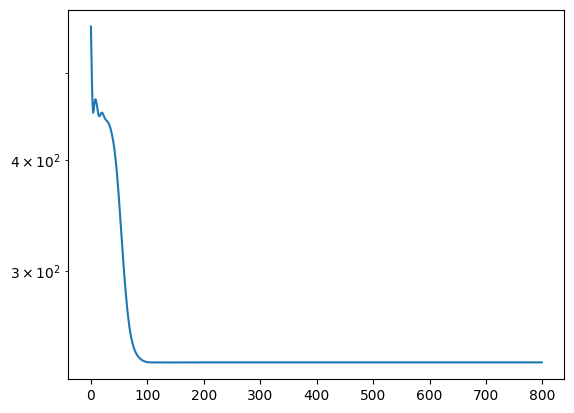

0.38383838383838387


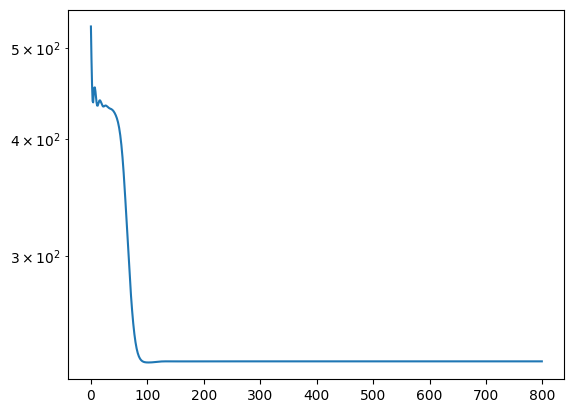

0.393939393939394


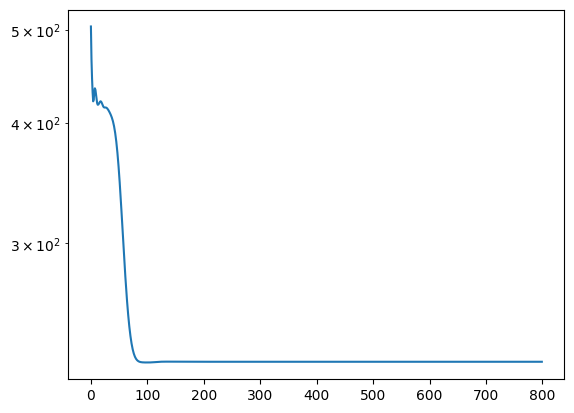

0.4040404040404041


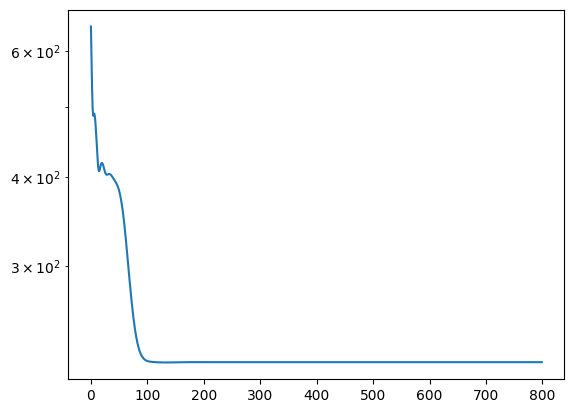

0.4141414141414142


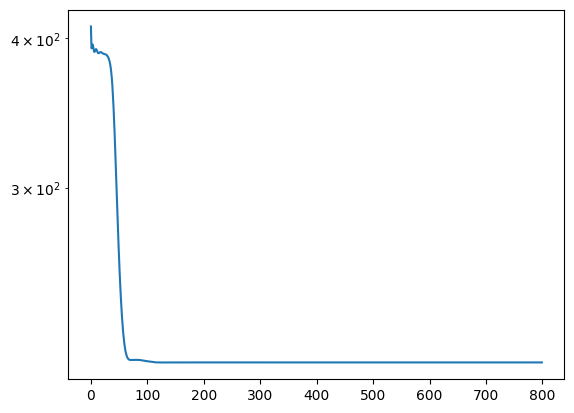

0.42424242424242425


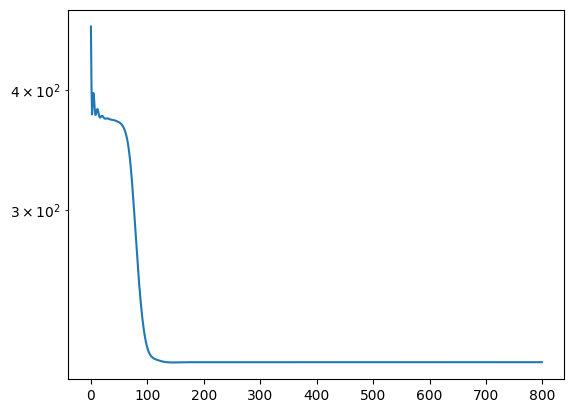

0.43434343434343436


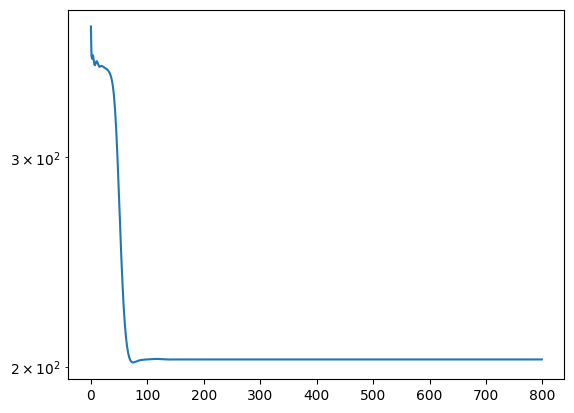

0.4444444444444445


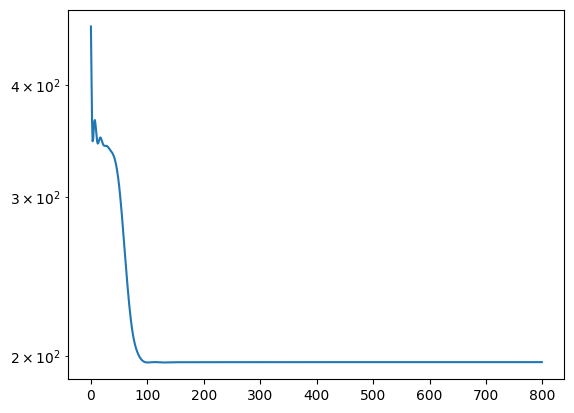

0.4545454545454546


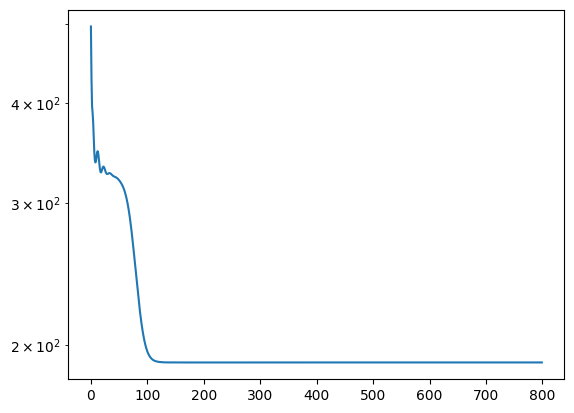

0.4646464646464647


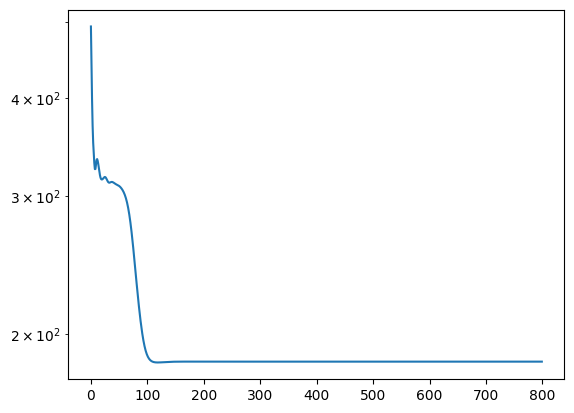

0.4747474747474748


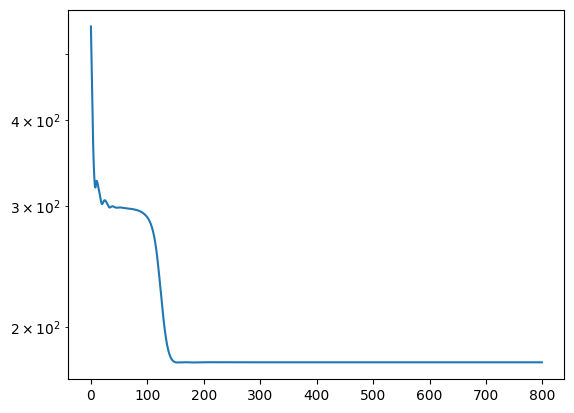

0.48484848484848486


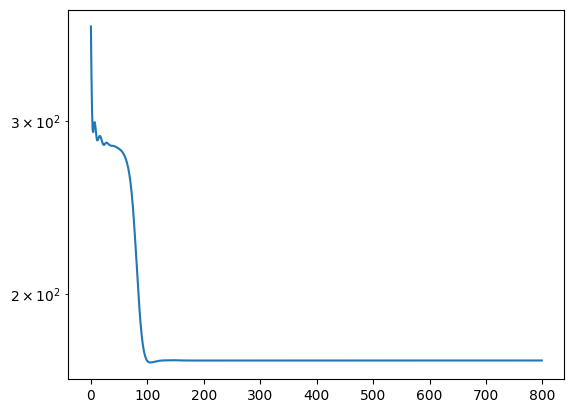

0.494949494949495


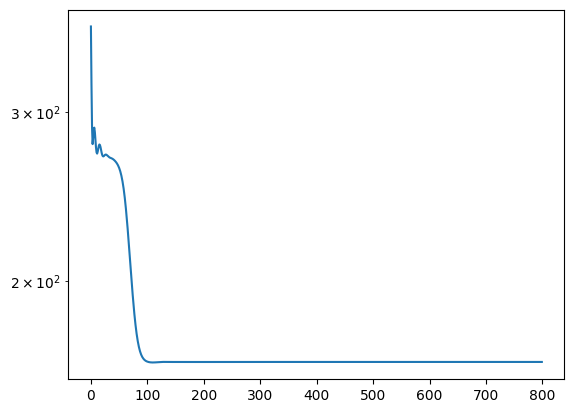

0.5050505050505051


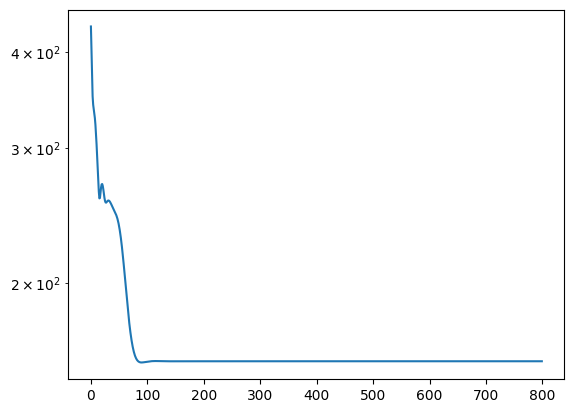

0.5151515151515152


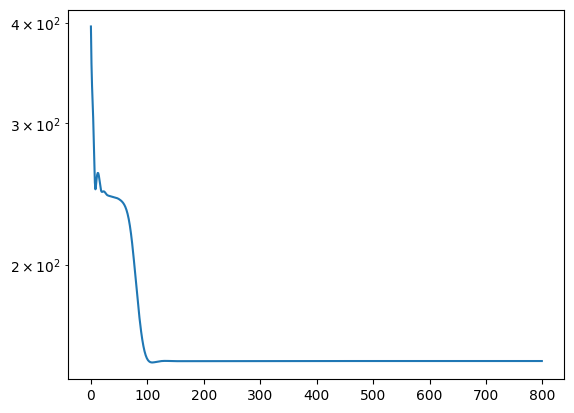

0.5252525252525253


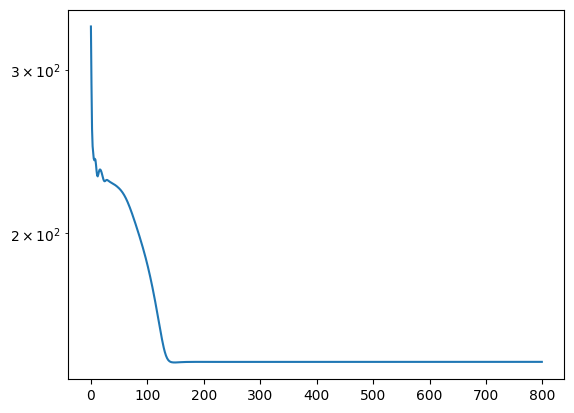

0.5353535353535354


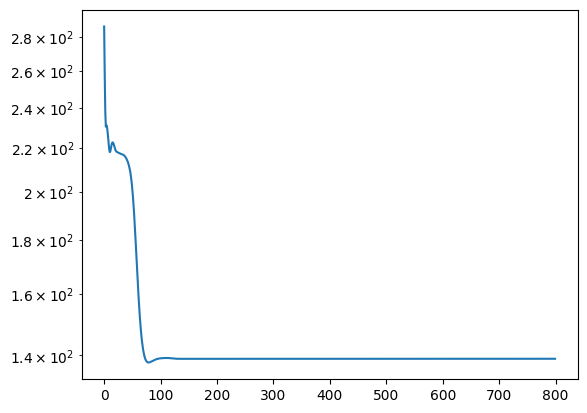

0.5454545454545455


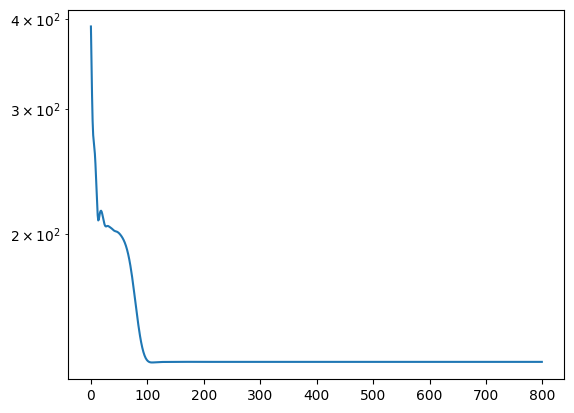

0.5555555555555556


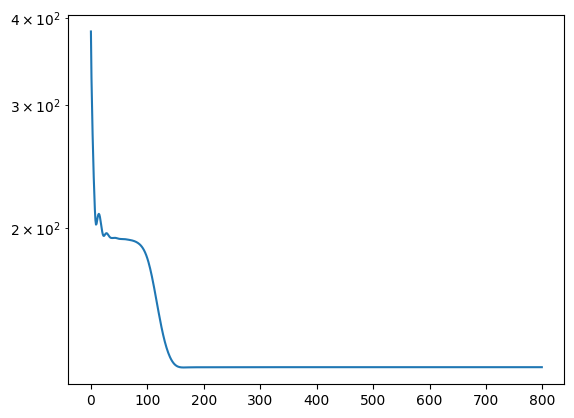

0.5656565656565657


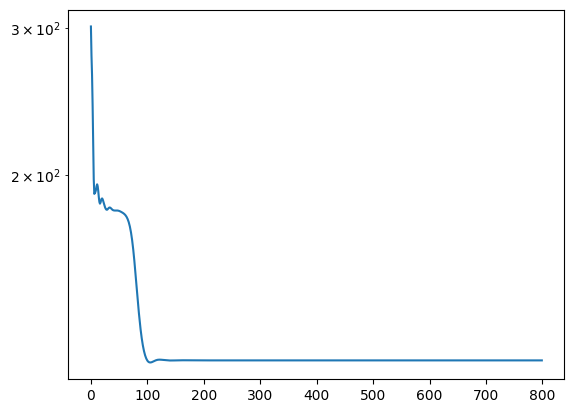

0.5757575757575758


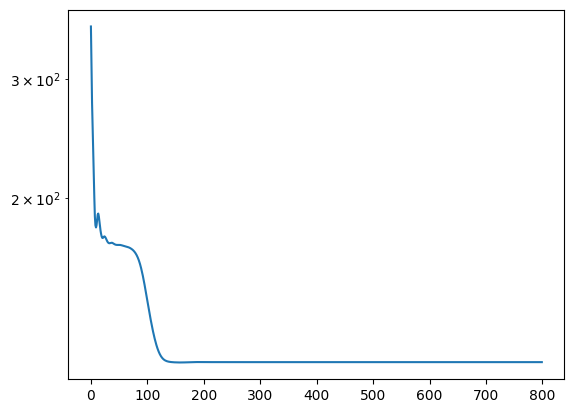

0.5858585858585859


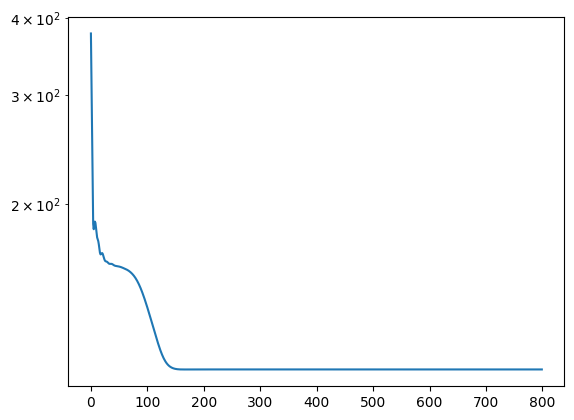

0.595959595959596


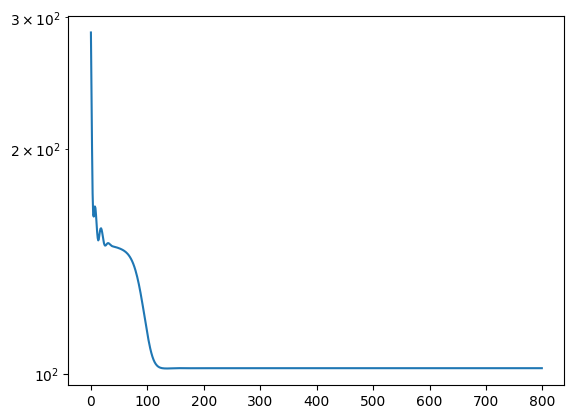

0.6060606060606061


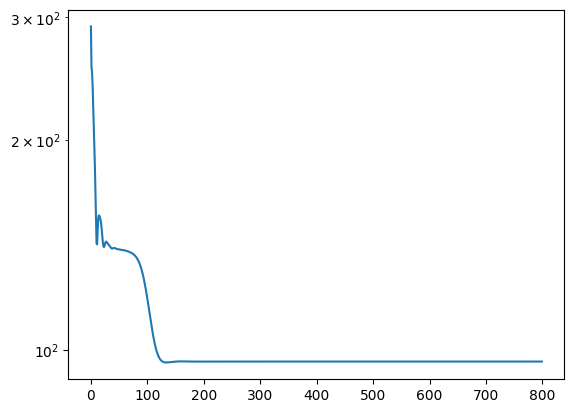

0.6161616161616162


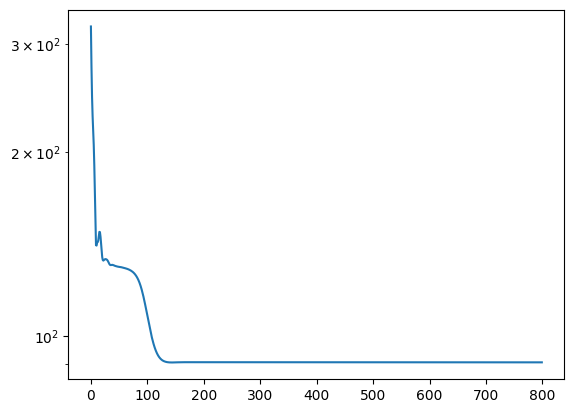

0.6262626262626263


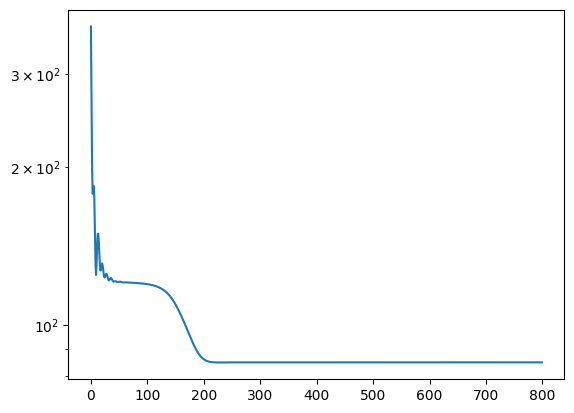

0.6363636363636365


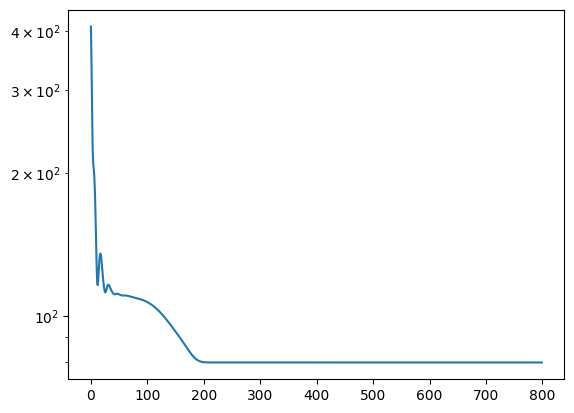

0.6464646464646465


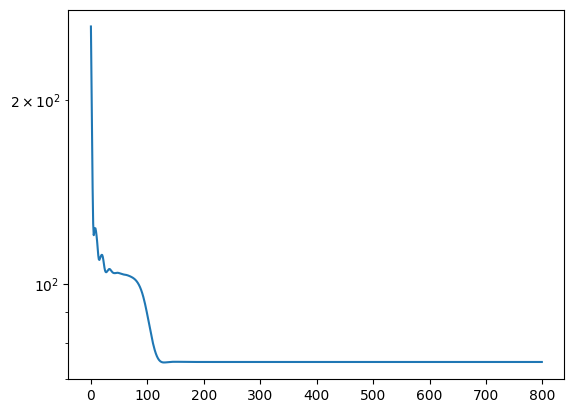

0.6565656565656566


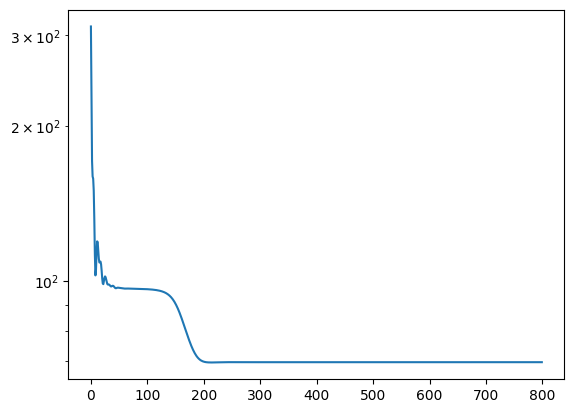

0.6666666666666667


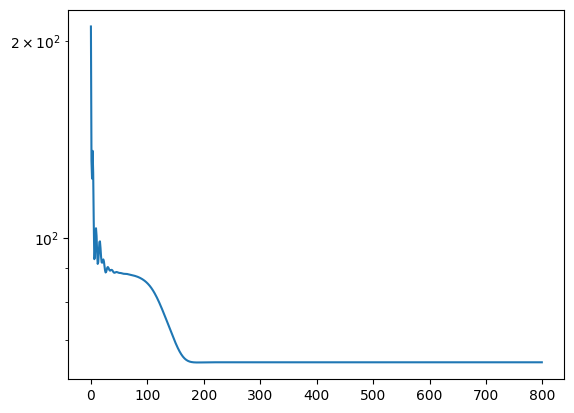

0.6767676767676768


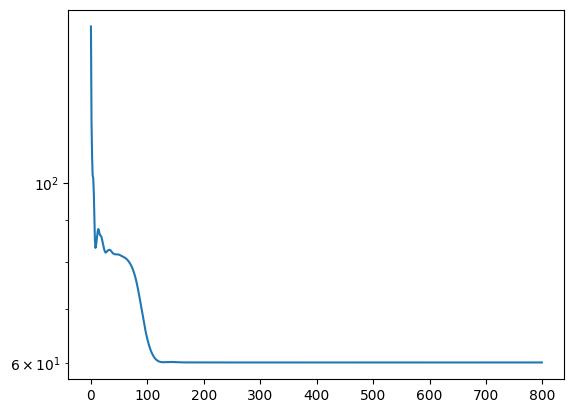

0.686868686868687


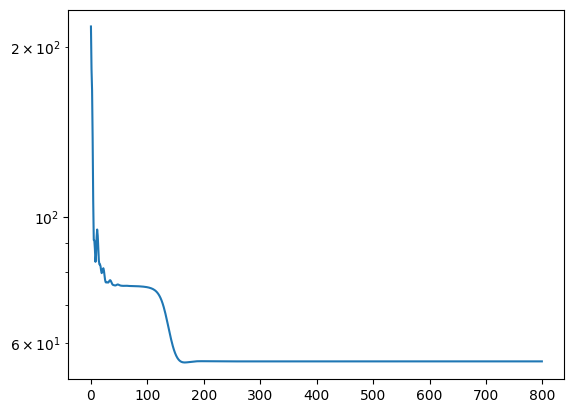

0.696969696969697


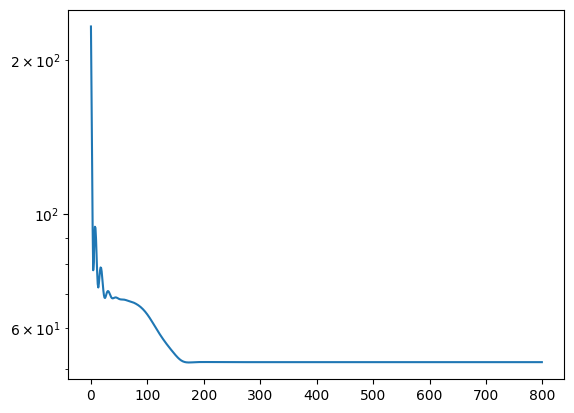

0.7070707070707072


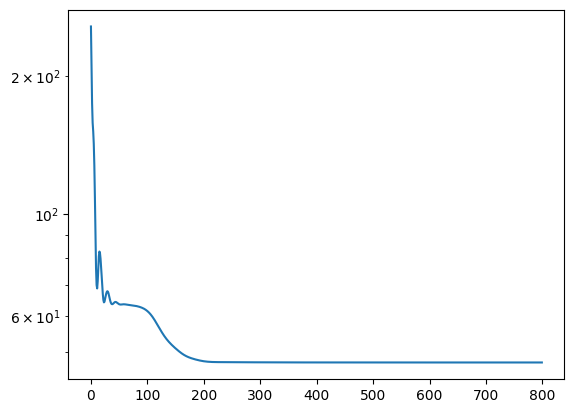

0.7171717171717172


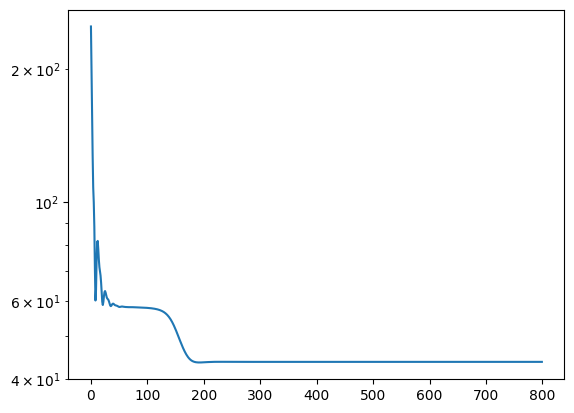

0.7272727272727273


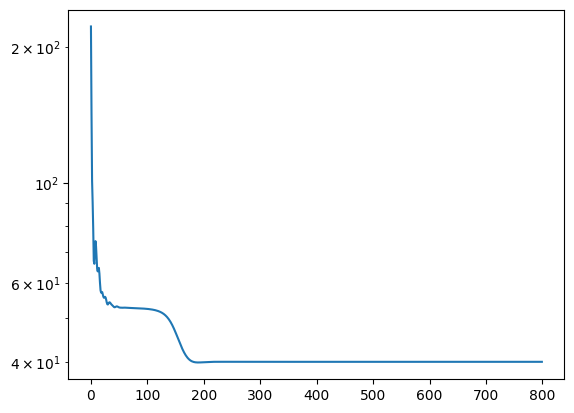

0.7373737373737375


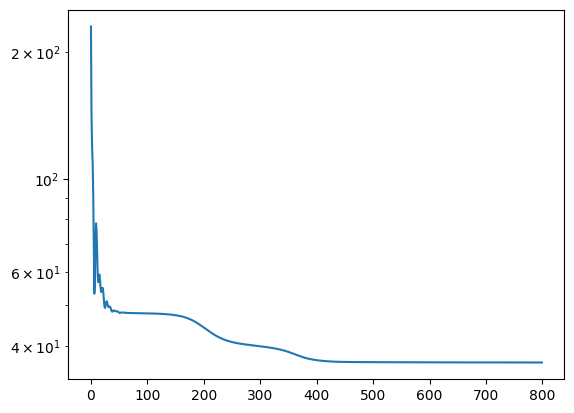

0.7474747474747475


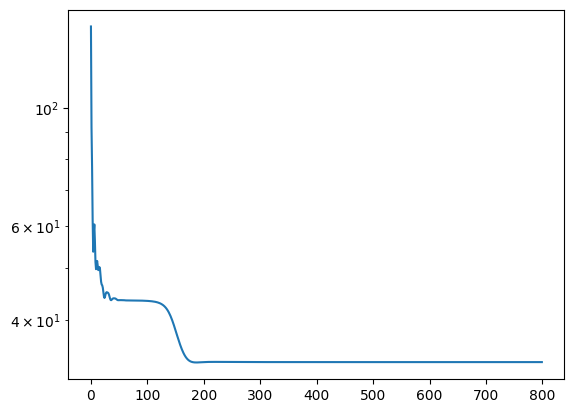

0.7575757575757577


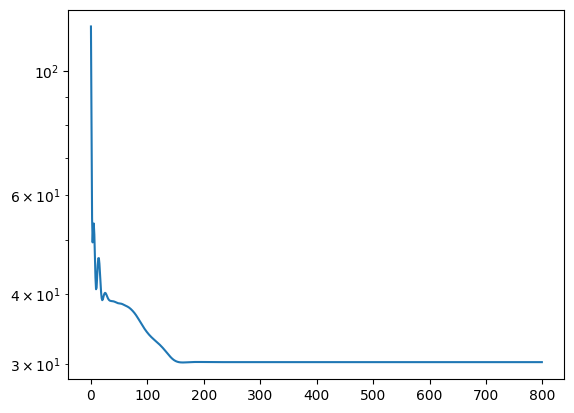

0.7676767676767677


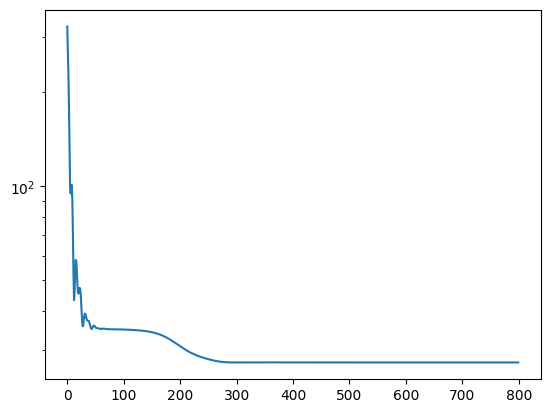

0.7777777777777778


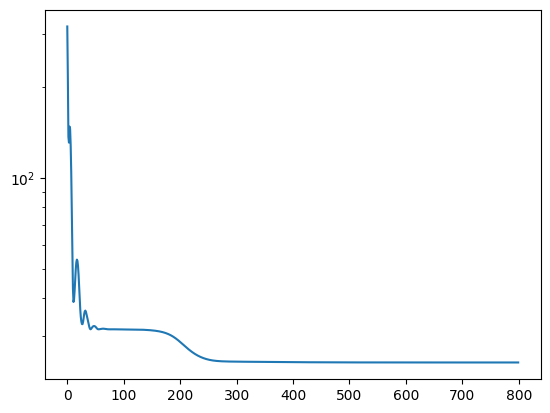

0.787878787878788


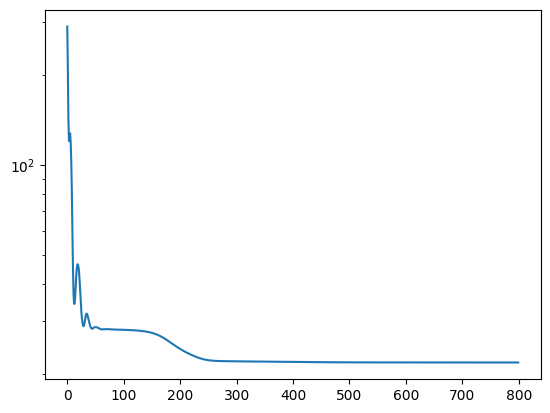

0.797979797979798


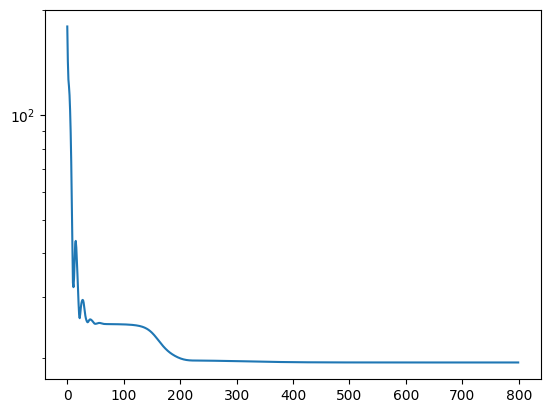

0.8080808080808082


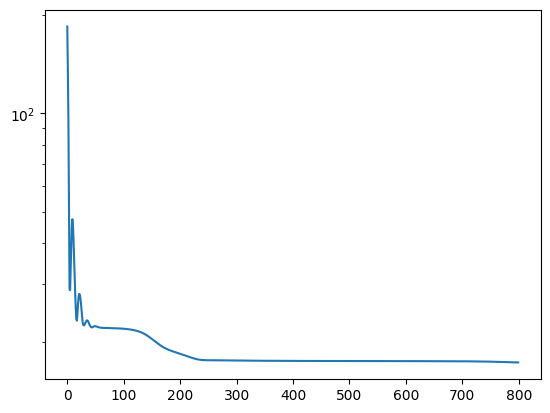

0.8181818181818182


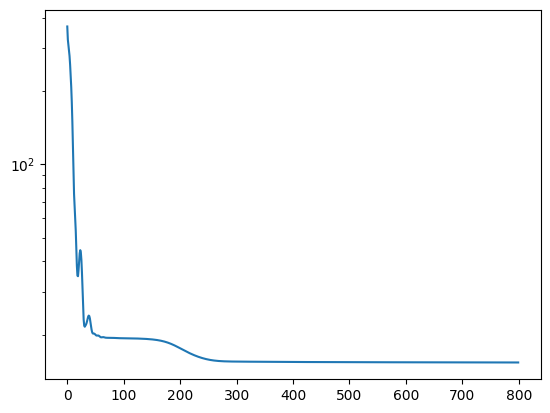

0.8282828282828284


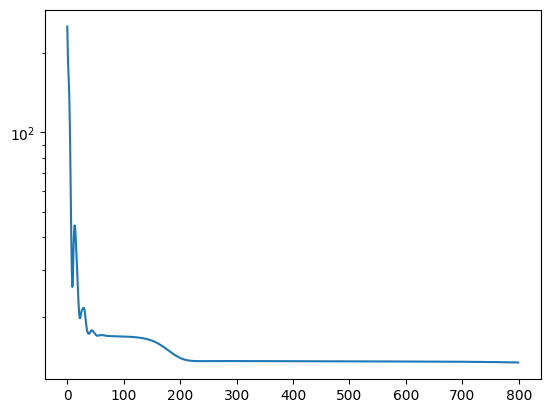

0.8383838383838385


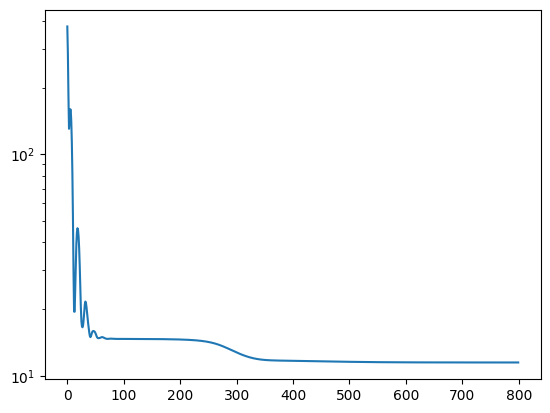

0.8484848484848485


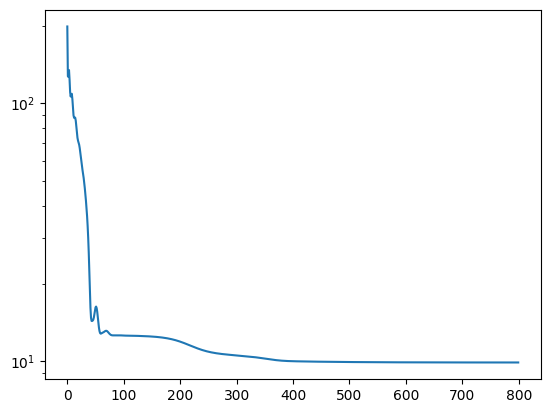

0.8585858585858587


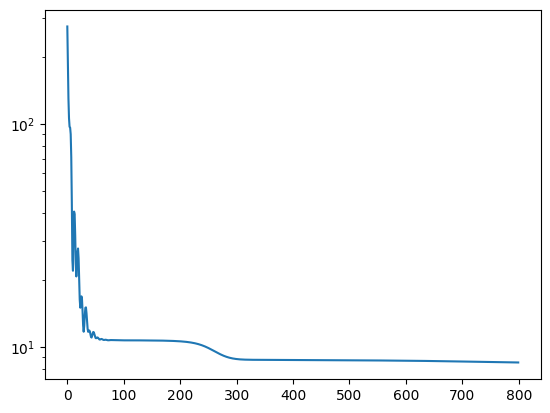

0.8686868686868687


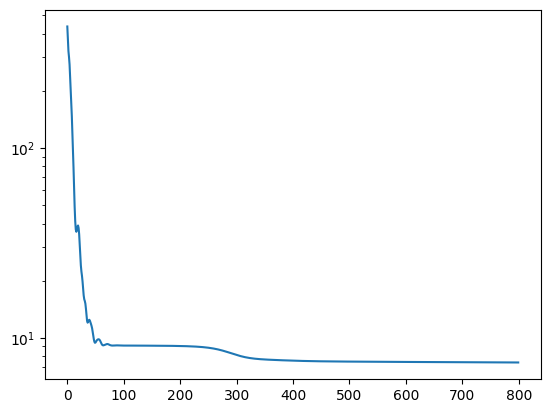

0.8787878787878789


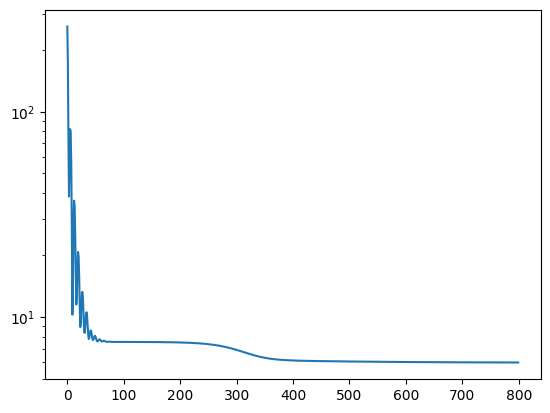

0.888888888888889


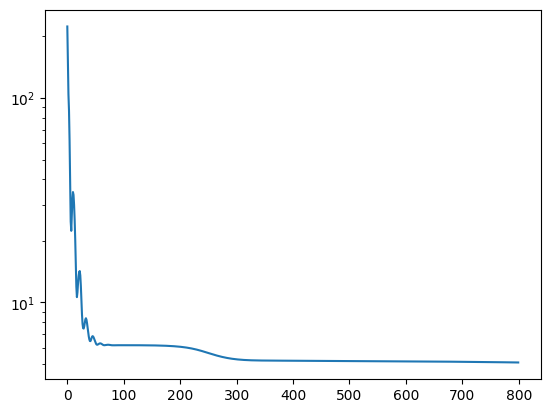

0.8989898989898991


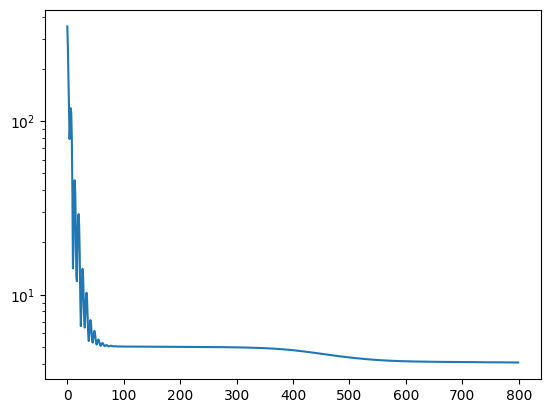

0.9090909090909092


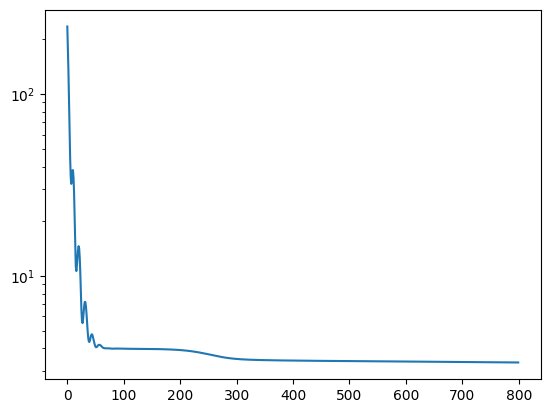

0.9191919191919192


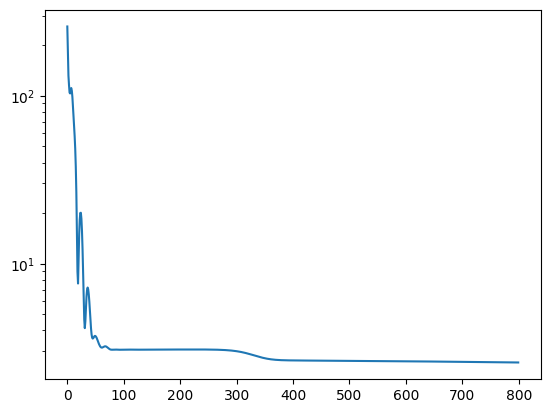

0.9292929292929294


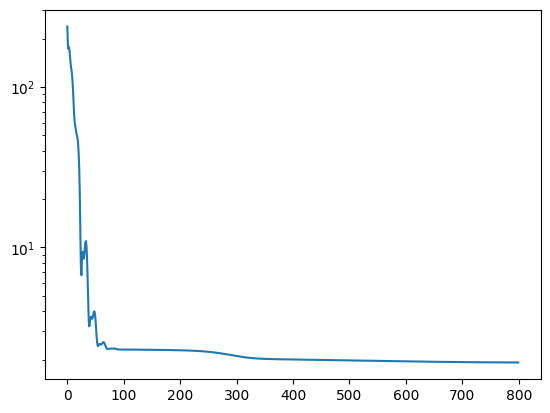

0.9393939393939394


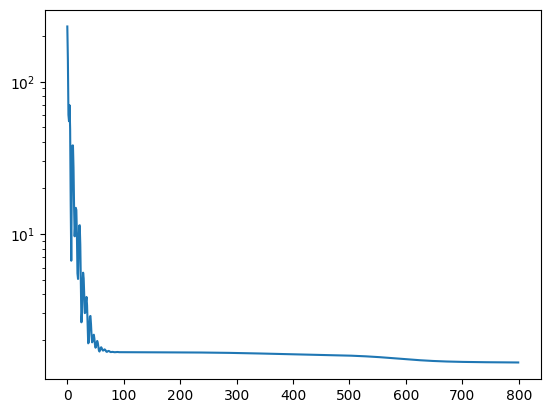

0.9494949494949496


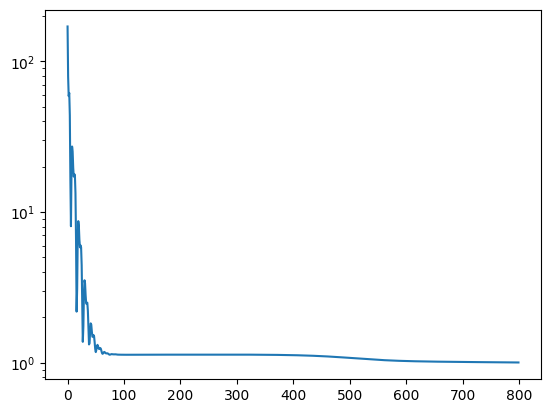

0.9595959595959597


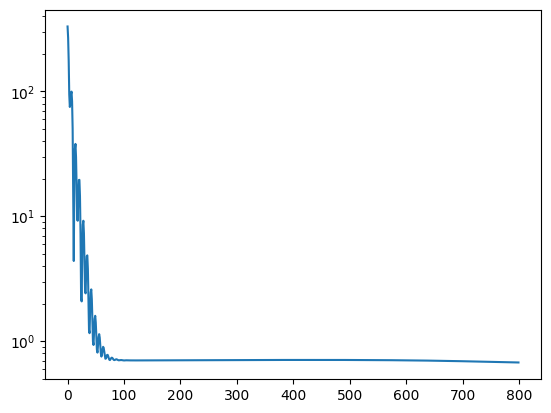

0.9696969696969697


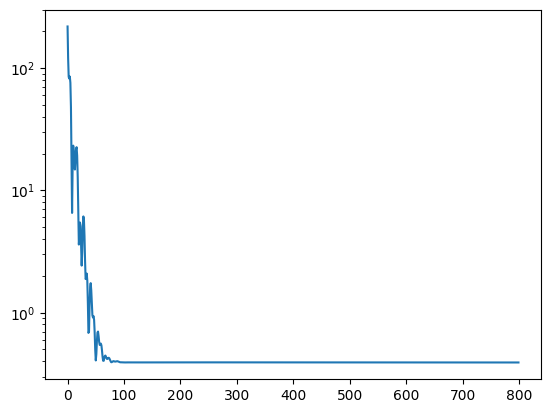

0.9797979797979799


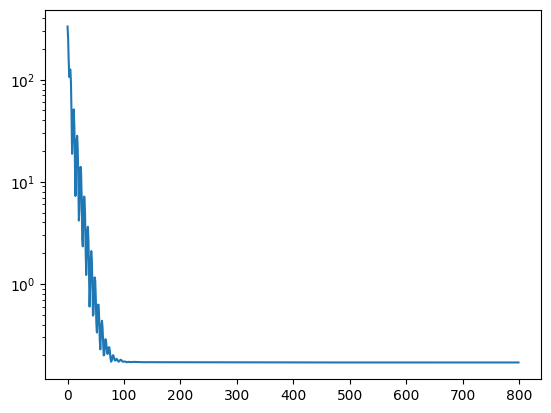

0.98989898989899


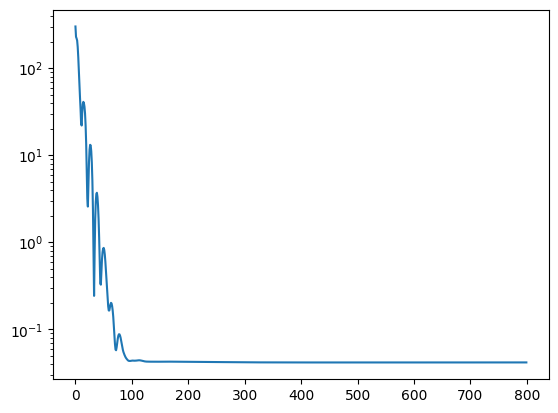

[0.9998169620690657, 0.9784501413818621, 0.9577095059553264, 0.9375967947577319, 0.9181134940119442, 0.8992608068928445, 0.8810396202800801, 0.8634504844793927, 0.8464935928995095, 0.8301687757056978, 0.814475493906452, 0.7994128426712155, 0.7849795658530767, 0.7711740716696183, 0.7579944608194313, 0.7454385598116936, 0.7335039600231696, 0.722188059527905, 0.7114881138281807, 0.7014012839780613, 0.6919246909297246, 0.6830554696898665, 0.6747908205284382, 0.6671280607414736, 0.6600646676486676, 0.6535983185529683, 0.6477269202852871, 0.6424486393663849, 0.6377619108018936, 0.6336654514392656, 0.6301582610762207, 0.6272396172019925, 0.6249090623130997, 0.6231663953650695, 0.622011652731753, 0.6214451279824965, 0.6214672089499735, 0.6220785743882914, 0.6232800395434297, 0.6250725623517703, 0.627457239810695, 0.630444859559387, 0.6340176317402506, 0.6381865428813975, 0.6429531258200437, 0.6483189708381232, 0.6542858089618889, 0.660855291153134, 0.6680292780276912, 0.6758096383014898, 0.684

In [9]:
# N samples which will be transported by the flow.
# At time t, X~\rho_t
X=np.random.randn(N,d) * std

Mt=((X.T*np.sign(X@mu)).T)@mu/d
M_ξ =((X.T*np.sign(X@mu)).T)@ξ_tot/d
M_η=((X.T*np.sign(X@mu)).T)@η_tot/d

X_=(X.T*np.sign(X@mu)).T
Simi=X_@mu/np.sqrt(d)/np.sqrt(np.sum(X_**2, 1))

summary["Mag"].append(Mt.mean())
summary["Mag_std"].append(Mt.std())
summary["t"].append(0)
summary["Mag_ξ"].append(M_ξ.mean())
summary["Mag_η"].append(M_η.mean())
summary["Cosine"].append(Simi.mean())
summary["Norm"].append(np.sum(X_**2)/X_.shape[0]/d)

ts=np.linspace(0.,1,N_steps)[:-1]

for t in ts:
    print(t)
    X_train=generate_data(ntot,μ,σ=σ,t=t)
    train_loader=DataLoader(X_train,batch_size=int(ntot))
    train(train_loader,t)

print(summary["Norm"])

mu_simu=((X.T*np.sign(X@mu)).T).mean(axis=0)   #computing \hat{\mu}, the cluster mean of the estimated density

# np.save("mu_n{}_norm{}_sig{}.npy".format(ntot,nrm,sigma),mu_simu)

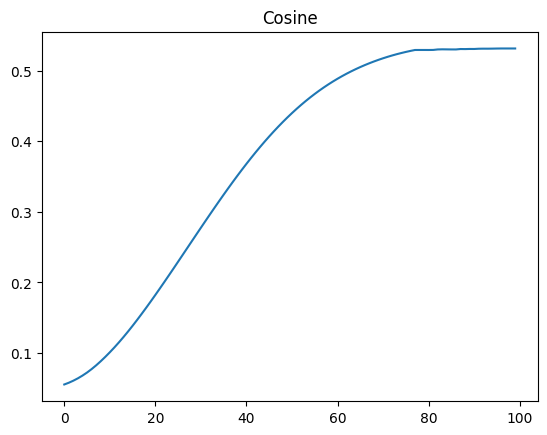

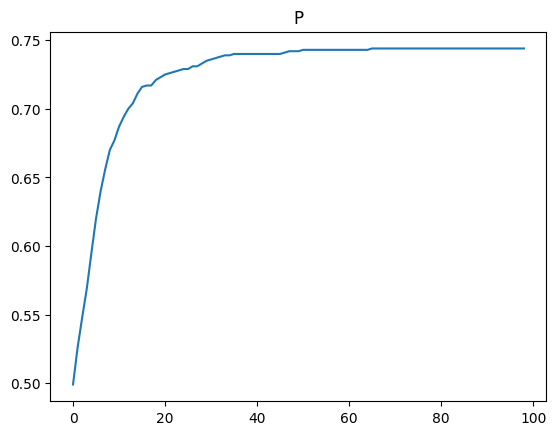

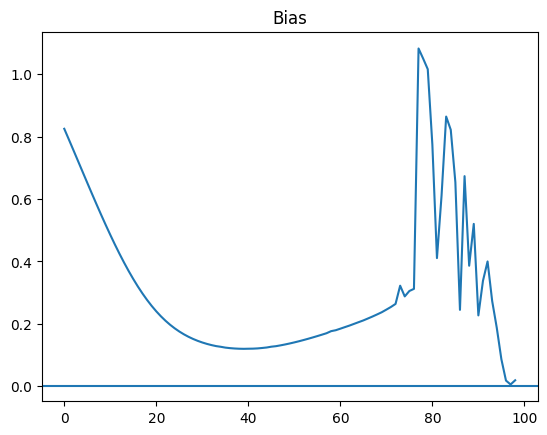

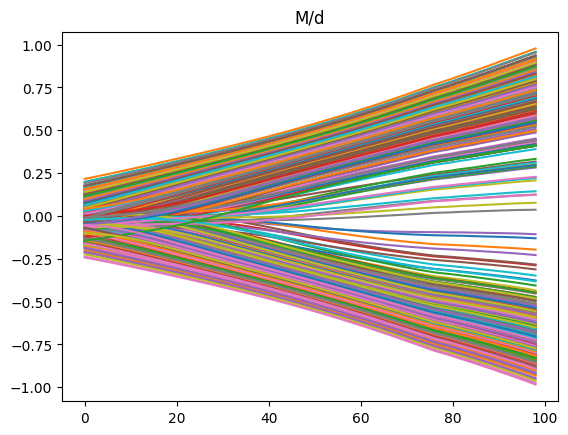

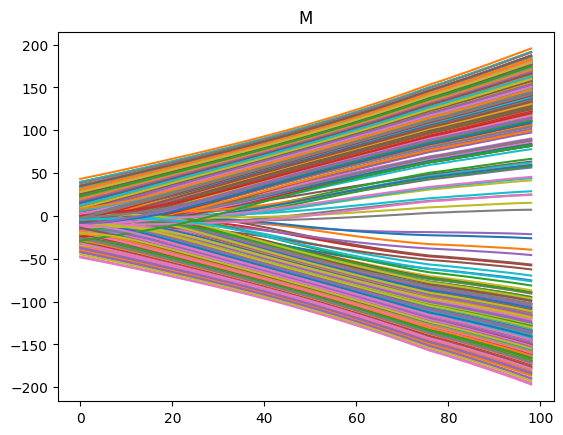

In [10]:
plt.plot(summary["Cosine"])
plt.title("Cosine")
plt.show()
plt.plot(summary["p"])
plt.title("P")
plt.show()
plt.plot(np.abs(summary["b"]))
plt.title("Bias")
plt.axhline(0)
plt.show()
plt.plot(np.array(summary["M_t"])/ d);
plt.title("M/d")
plt.show()
plt.plot(np.array(summary["M_t"]));
plt.title("M")
plt.show()